# 1. 定义算法
QLearning是一种用于强化学习的算法,它可以用于找到一个Markov决策过程(MDP)中的最优行动策略。它的主要思想是:
1. 算法使用Q函数来确定状态-行动(state-action)值函数。Q函数定义为:Q(s, a)返回执行行动a在状态s下的最大化期望回报。
2. Q函数通过迭代更新,使用新的经验来改进值函数。更新公式为:
$$Q(s, a) <- Q(s, a) + alpha * (reward + gamma * max_a' Q(s', a') - Q(s, a))$$ 
- s和s'分别表示当前状态和下一状态,a和a'表示当前行动和下一行动
- alpha是学习率,控制更新的量
- reward 是执行行动a在状态s后获得的奖励
- gamma是折扣因子,衰减了max_a' Q(s', a')的值
3. 根据Q函数选择行动策略。通常使用ε-greedy策略,以概率ε选择随机行动,否则选择Q值最大的行动。
4. 通过大量迭代并Decaying ε, QLearning可以收敛到最优策略。
QLearning的好处是:
1. 可以在不需要环境模型的情况下工作,只需要环境的奖励反馈。
2. 可以确保找到最优解,如果探索足够的话。
3. 相比 SARSA 算法简单易理解。
4. 易于实现,代码量少。

## 1.1定义模型

In [10]:
import numpy as np
import math
import torch
from collections import defaultdict

class Qlearning(object):
    def __init__(self,cfg):
        '''智能体类
        Args:
            cfg (class): 超参数类
        '''
        self.n_actions = cfg.n_actions 
        self.exploration_type = 'e-greedy' # 探索策略如 e-greedy ，boltzmann ，softmax， ucb 等
        self.lr = cfg.lr 
        self.gamma = cfg.gamma    
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(self.n_actions)) # 使用嵌套字典来表示 Q(s,a)，并将指定所有的 Q_table 创建时， Q(s,a) 初始设置为 0
    def sample_action(self, state):
        ''' 以 e-greedy 策略训练时选择动作 
        Args:
            state (array): 状态
        Returns:
            action (int): 动作
        ''' 
        if self.exploration_type == 'e-greedy':
            action = self._epsilon_greedy_sample_action(state)
        else:
            raise NotImplementedError
        return action
    def predict_action(self,state):
        ''' 预测动作
        Args:
            state (array): 状态
        Returns:
            action (int): 动作
        '''
        if self.exploration_type == 'e-greedy':
            action = self._epsilon_greedy_predict_action(state)
        else:
            raise NotImplementedError
        return action
    def _epsilon_greedy_sample_action(self, state):
        ''' 
        采用 epsilon-greedy 策略进行动作选择 
        Args: 
            state (array): 状态
        Returns: 
            action (int): 动作
        ''' 
        self.sample_count += 1
        # epsilon 值需要衰减，衰减方式可以是线性、指数等，以平衡探索和开发
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择具有最大 Q 值的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选择一个动作
        return action
    def _epsilon_greedy_predict_action(self,state):
        ''' 
        使用 epsilon-greedy 算法进行动作预测 
        Args: 
            state (array): 状态
        Returns: 
            action (int): 动作 
        ''' 
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, done):
        ''' 更新模型
        Args:
            state (array): 当前状态 
            action (int): 当前动作 
            reward (float): 当前奖励信号 
            next_state (array): 下一个状态 
            done (bool): 表示是否达到终止状态 
        '''
        Q_predict = self.Q_table[str(state)][action] 
        if done: # 终止状态 
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)
    def save_model(self,path):
        '''
        保存模型
        Args:
            path (str): 模型存储路径 
        '''
        import dill
        from pathlib import Path
        # 确保存储路径存在 
        Path(path).mkdir(parents=True, exist_ok=True)
        torch.save(
            obj=self.Q_table,
            f=path+"Qleaning_model.pkl",
            pickle_module=dill
        )
        print("Model saved!")
    def load_model(self, path):
        '''
        根据模型路径导入模型
        Args:
            fpath (str): 模型路径
        '''
        import dill
        self.Q_table =torch.load(f=path+'Qleaning_model.pkl',pickle_module=dill)
        print("Mode loaded!")

## 1.2定义模型训练与测试

In [11]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 一轮的累计奖励 
        ep_step = 0
        state = env.reset(seed = cfg.seed)  # 重置环境并获取初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 采样动作 
            if cfg.new_step_api:
                next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境并返回新状态、奖励、终止状态、截断标志和其他信息（使用 OpenAI Gym 的 new_step_api）
            else:
                next_state, reward, terminated, info = env.step(action)  # 更新环境并返回新状态、奖励、终止状态和其他信息（使用 OpenAI Gym 的 old_step_api） 
            agent.update(state, action, reward, next_state, terminated)  # 更新 agent
            state = next_state  # 更新状态 
            ep_reward += reward  # 增加奖励 
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 一轮的累计奖励 
        ep_step = 0
        state = env.reset(seed = cfg.seed)  # 重置环境并获取初始状态 
        for _ in range(cfg.max_steps):
            if cfg.render:
                env.render()
            ep_step += 1
            action = agent.predict_action(state)  # 预测动作 
            next_state, reward, terminated, truncated , info = env.step(action)
            state = next_state  # 更新状态 
            ep_reward += reward  # 增加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}


## 1.3定义环境

In [12]:
import gymnasium as gym
import os
import random
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.reset(seed=seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    print(env.observation_space.shape)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = Qlearning(cfg)
    return env,agent

# 2.设置参数
在这里定义我们的通用参数以及Qlearning参数

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self) -> None:
        ## 通用参数
        self.env_name = "CliffWalking-v0" # name of environment
        self.new_step_api = True # whether to use new step api of gym
        self.wrapper = None # wrapper of environment
        self.render = False # whether to render environment
        self.render_mode = "human" # 渲染模式, "human" 或者 "rgb_array"
        self.algo_name = "Qlearning" # name of algorithm
        self.mode = "train" # train or test
        self.mp_backend = "mp" # 多线程框架，ray或者mp(multiprocessing)，默认mp
        self.seed = 1 # random seed
        self.device = "cuda" # device to use
        self.train_eps = 500 # number of episodes for training
        self.test_eps = 10 # number of episodes for testing
        self.eval_eps = 10 # number of episodes for evaluation
        self.eval_per_episode = 5 # evaluation per episode
        self.max_steps = 1000 # max steps for each episode
        self.load_checkpoint = False
        self.load_path = "tasks" # path to load model
        self.show_fig = False # show figure or not
        self.save_fig = True # save figure or not

        ## Qlearing参数
        self.epsilon_start = 0.95 # epsilon 初始值
        self.epsilon_end = 0.01 # epsilon 终止值
        self.epsilon_decay = 300 # epsilon 衰减率
        self.gamma = 0.90 # 奖励折扣因子
        self.lr = 0.1 # 学习率

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('episodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

# 3.开始训练

()
状态空间维度：48，动作空间维度：4
开始训练！
回合：10/500，奖励：-155.00
回合：20/500，奖励：-126.00
回合：30/500，奖励：-78.00
回合：40/500，奖励：-48.00
回合：50/500，奖励：-33.00
回合：60/500，奖励：-32.00
回合：70/500，奖励：-88.00
回合：80/500，奖励：-29.00
回合：90/500，奖励：-63.00
回合：100/500，奖励：-54.00
回合：110/500，奖励：-33.00
回合：120/500，奖励：-28.00
回合：130/500，奖励：-33.00
回合：140/500，奖励：-35.00
回合：150/500，奖励：-48.00
回合：160/500，奖励：-25.00
回合：170/500，奖励：-23.00
回合：180/500，奖励：-20.00
回合：190/500，奖励：-29.00
回合：200/500，奖励：-19.00
回合：210/500，奖励：-19.00
回合：220/500，奖励：-20.00
回合：230/500，奖励：-19.00
回合：240/500，奖励：-17.00
回合：250/500，奖励：-26.00
回合：260/500，奖励：-25.00
回合：270/500，奖励：-13.00
回合：280/500，奖励：-23.00
回合：290/500，奖励：-13.00
回合：300/500，奖励：-13.00
回合：310/500，奖励：-13.00
回合：320/500，奖励：-14.00
回合：330/500，奖励：-14.00
回合：340/500，奖励：-13.00
回合：350/500，奖励：-13.00
回合：360/500，奖励：-13.00
回合：370/500，奖励：-13.00
回合：380/500，奖励：-13.00
回合：390/500，奖励：-13.00
回合：400/500，奖励：-13.00
回合：410/500，奖励：-13.00
回合：420/500，奖励：-13.00
回合：430/500，奖励：-13.00
回合：440/500，奖励：-13.00
回合：450/500，奖励：-13.00
回合：460/500，奖励：-13.00
回合：470/500，奖励

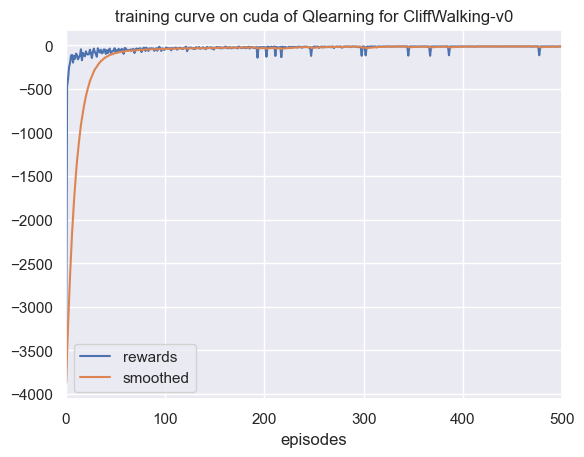

开始测试！
回合：1/10，奖励：-13.00
回合：2/10，奖励：-13.00
回合：3/10，奖励：-13.00
回合：4/10，奖励：-13.00
回合：5/10，奖励：-13.00
回合：6/10，奖励：-13.00
回合：7/10，奖励：-13.00
回合：8/10，奖励：-13.00
回合：9/10，奖励：-13.00
回合：10/10，奖励：-13.00
完成测试


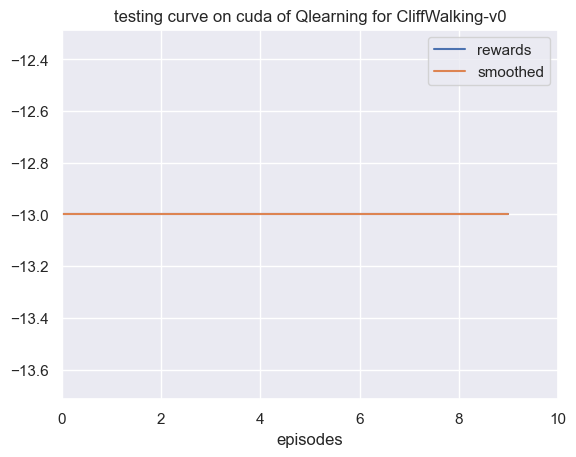

In [14]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果